In [81]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import resample
import xgboost as xgb 


c:\Winapp\Anaconda\envs\py38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load saved data

In [4]:
os.getcwd()
os.chdir(r"D:\sep22_10_supply_chain\data")

In [5]:
data_en = pd.read_pickle(r"data_en.pickle")

In [6]:
data_en.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,language,processed_reviews
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,EN,use elit danger mac amaz joystick especi love ...
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31,EN,love even realis game mous type silent mous se...
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31,EN,poor qualiti advertis
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31,EN,nice tend slip away stick intens hard press ga...
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31,EN,great amiibo great collect qualiti materi desi...


# Undersampling to reduce calculation load and balance data

In [7]:
X = data_en["processed_reviews"]
y = data_en["star_rating"]

In [8]:
a = [resample(X[y == sr], y[y == sr], replace=True, n_samples=int(np.floor((X[y == 2].shape[0])*0.5)), random_state=123) for sr in [1,2,3,4,5]]

#X_undersampled_5, y_undersampled_5 = resample(X[y == 5], y_imbalanced[y_imbalanced == 1],
#                replace=True,
#                n_samples=X_imbalanced[y_imbalanced == 0].shape[0],
#                random_state=123)

In [9]:
X_list = [a[r][0] for r in range(5)]
y_list = [a[r][1] for r in range(5)]

X_us = np.hstack(X_list)
y_us = np.hstack(y_list)
#a[1][1]


In [10]:
X_us.shape

(234800,)

# Split data into train, test and val

In [11]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X_us, y_us, test_size= 0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, random_state=42)

# Illustrate class imbalance

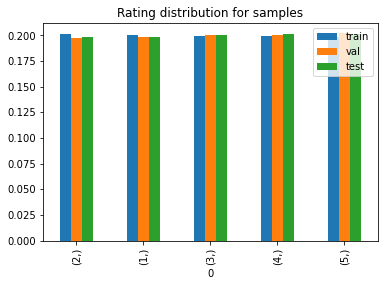

In [12]:
pd.concat([pd.DataFrame(x).value_counts(normalize=1) for x in [y_train, y_val, y_test]], axis=1).rename({0:"train", 1:"val", 2:"test"}, axis=1).plot(kind="bar")
plt.title("Rating distribution for samples");


# Vectorization

Idea: Define a function performing vectorization, to make it easy to add other methods

In [115]:
def tf_idf_transformer(X_train, X_val):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)
    X_train_counts.shape
    #tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
    #X_train_tf = tf_transformer.transform(X_train_counts)
    #X_train_tf.shape
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    #X_train_tfidf.shape
    X_val_tfidf = count_vect.transform(X_val)
    X_val_tfidf = tfidf_transformer.transform(X_val_tfidf)    
    up = 100#.999
    dn = 5#0.001
    X_train_tfidf_out = X_train_tfidf[:, np.flatnonzero(np.logical_and(X_train_tfidf.mean(axis=0)>=np.percentile(X_train_tfidf.mean(axis=0),dn),X_train_tfidf.mean(axis=0)<=np.percentile(X_train_tfidf.mean(axis=0),up)))]
    X_val_tfidf = X_val_tfidf[:, np.flatnonzero(np.logical_and(X_train_tfidf.mean(axis=0)>=np.percentile(X_train_tfidf.mean(axis=0),dn),X_train_tfidf.mean(axis=0)<=np.percentile(X_train_tfidf.mean(axis=0),up)))]
    ccc = np.array(np.logical_and(X_train_tfidf.mean(axis=0)>=np.percentile(X_train_tfidf.mean(axis=0),dn),X_train_tfidf.mean(axis=0)<=np.percentile(X_train_tfidf.mean(axis=0),up)))    
    feature_names = np.array(count_vect.get_feature_names())[ccc.ravel()]
    if (True):
        selector = VarianceThreshold(0.00005/1)
        X_train_tfidf_out = selector.fit_transform(X_train_tfidf_out)
        X_val_tfidf = selector.transform(X_val_tfidf)
        feature_names = selector.transform(feature_names.reshape(1, -1))

    
    

    return X_train_tfidf_out, X_val_tfidf, feature_names





def count_transformer(X_train, X_val):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)
    X_val_counts = count_vect.transform(X_val)    
    return X_train_counts, X_val_counts, count_vect.get_feature_names()

In [116]:
def return_vector(method, X_train, X_val):
    if (method == "tfidf"):
            x,y,z = tf_idf_transformer(X_train, X_val)            
    elif (method == "bow"):
            x, y, z = count_transformer(X_train, X_val)        
        # If an exact match is not confirmed, this last case will be used if provided
    else:
            print("Error")
    print(method)
    return x, y, z


X_train_vectorized, X_val_vectorized, feature_names = return_vector("tfidf",X_train, X_val)




tfidf


c:\Winapp\Anaconda\envs\py38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [122]:
print(X_train_vectorized.shape, X_val_vectorized.shape)

(140880, 2779) (70440, 2779)


In [99]:
dict(zip(feature_names.ravel() , X_train_vectorized.mean(axis=1))) 
#stopwrods: xbox, nintendo, game, amazon, christma, gamecub, im, mario, around, basketbal

{'aa': matrix([[0.00034342]]),
 'aaa': matrix([[0.00059032]]),
 'ab': matrix([[0.00056063]]),
 'abacus': matrix([[0.00032889]]),
 'abandon': matrix([[0.00041731]]),
 'abba': matrix([[0.00022538]]),
 'abc': matrix([[0.00030099]]),
 'abd': matrix([[0.0004535]]),
 'abe': matrix([[0.00020932]]),
 'abil': matrix([[0.00026331]]),
 'abilit': matrix([[0.00029385]]),
 'abit': matrix([[0.00039747]]),
 'abl': matrix([[0.00049444]]),
 'abnorm': matrix([[0.00059856]]),
 'abomin': matrix([[0.00100907]]),
 'abort': matrix([[0.00063437]]),
 'abound': matrix([[0.00019273]]),
 'abras': matrix([[0.00037401]]),
 'abroad': matrix([[0.0004026]]),
 'abrupt': matrix([[0.00032712]]),
 'absenc': matrix([[0.00089944]]),
 'absent': matrix([[0.00090666]]),
 'absolut': matrix([[0.00101455]]),
 'absolutley': matrix([[0.00020835]]),
 'absorb': matrix([[0.00046401]]),
 'abstract': matrix([[0.00028085]]),
 'absurd': matrix([[0.00121324]]),
 'abt': matrix([[0.00052331]]),
 'abund': matrix([[0.00038551]]),
 'abus': matri

# Classification

In [46]:
clf_mnNB = MultinomialNB().fit(X_train_vectorized, y_train)


In [48]:
clf_knn = KNeighborsClassifier(n_neighbors=40).fit(X_train_vectorized, y_train)


In [44]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(max_iter=1000).fit(X_train_vectorized, y_train)

In [104]:
clf_lr_L2_05 = LogisticRegression( C=0.5,max_iter=1000).fit(X_train_vectorized, y_train)


In [103]:
clf_lr_L1_05 = LogisticRegression(penalty="l1", C=0.25,max_iter=1000, solver= "saga").fit(X_train_vectorized, y_train)

In [52]:
clf_lr_L2_01 = LogisticRegression( C=0.1,max_iter=1000).fit(X_train_vectorized, y_train)

In [119]:
clf_xgb = xgb.XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5,
              max_delta_step=0, max_depth=20, min_child_weight=1,# missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)



# fitting the model 




In [120]:
clf_xgb.fit(X_train_vectorized, y_train)

c:\Winapp\Anaconda\envs\py38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='mlogloss', gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
# Assessement of results
# Add vine flag as feature!

In [35]:
def assess_on_val(clf, X_val_vectorized, y_val):
    print("Start predicting")
    predicted = clf.predict(X_val_vectorized)
    print("Finished predicting")
    total_accuracy = metrics.accuracy_score(predicted, y_val)

    accuracy_by_rating_class = {rc : metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc]) for rc in data_en.star_rating.unique()}
    accuracy_by_rating_class = pd.DataFrame.from_dict(accuracy_by_rating_class, orient="index")

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(131)
    accuracy_by_rating_class.sort_index().plot(kind = "bar", ax = ax)
    ax.set_title("Accuracy per  \nrating class")
    ax.axhline(y = total_accuracy, color ='r', linestyle = '--')
    ax.get_legend().remove()
    ax.set_ylim(0,1)

    ax2 = fig.add_subplot(132)
    pd.DataFrame({"star_rating": predicted}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax2)
    ax2.set_title("Percentage of \n predicted rating class")
    ax2.get_legend().remove()
    ax2.set_ylim(0,1)

    ax3 = fig.add_subplot(133)
    pd.DataFrame({"star_rating": y_val}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax3)
    ax3.set_title("Percentage of actual \n rating classes in val")
    ax3.get_legend().remove()
    ax3.set_ylim(0,1)
    
    print("Global accuracy: " + str(total_accuracy))
    return fig





#metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc])

Start predicting
Finished predicting
Global accuracy: 0.4617830777967064


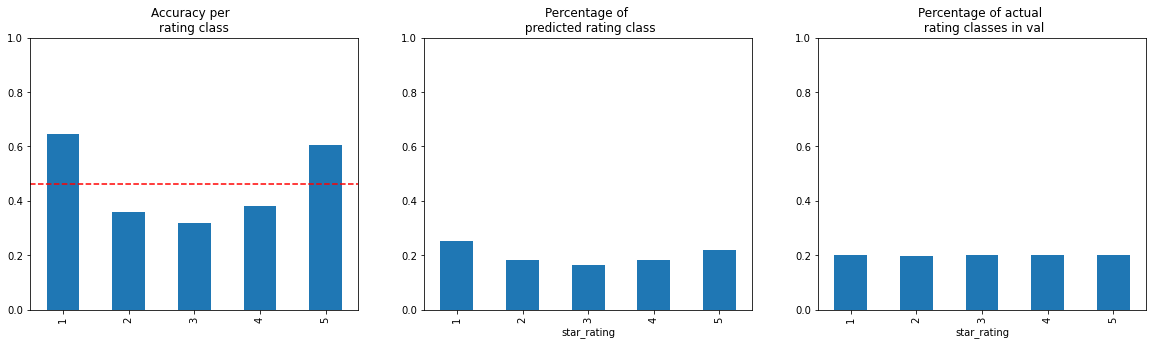

In [47]:

assess_on_val(clf_mnNB, X_val_vectorized, y_val);



In [187]:
X_val_vectorized.shape

(70440, 627)

In [49]:
assess_on_val(clf_knn, X_val_vectorized, y_val);

Start predicting


KeyboardInterrupt: 

In [93]:
assess_on_val(clf_lr, X_val_vectorized, y_val);

Start predicting


ValueError: X has 7037 features, but LogisticRegression is expecting 2779 features as input.

Start predicting
Finished predicting
Global accuracy: 0.5043441226575809


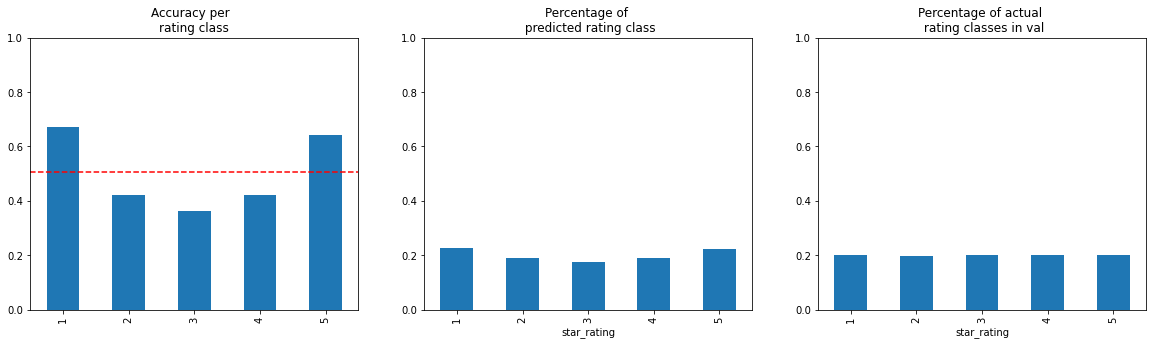

In [106]:
assess_on_val(clf_lr_L2_05, X_val_vectorized, y_val);

Start predicting
Finished predicting
Global accuracy: 0.49622373651334467


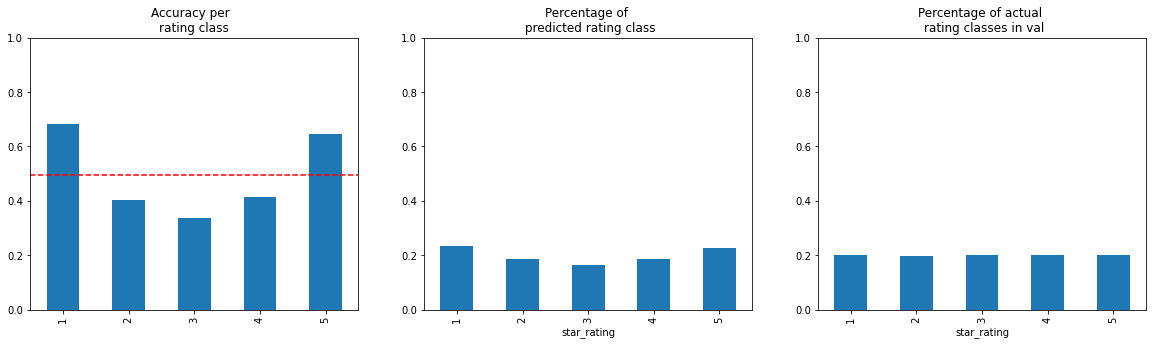

In [105]:
assess_on_val(clf_lr_L1_05, X_val_vectorized, y_val);

In [95]:
#Analyse words predicting class 0
coefs = pd.DataFrame.from_dict({"coef": clf_lr_L2_05.coef_[0,:], "feature": feature_names.ravel()}, orient="index")
coefs = coefs.transpose()
coefs["abs_coef"]=np.abs(coefs.coef)
coefs.sort_values(by="abs_coef", ascending=False).head(40)

,coef,feature,abs_coef
2663,-6.34947,great,6.34947
6921,6.003601,worst,6.003601
6764,5.691694,wast,5.691694
6136,5.129915,terribl,5.129915
3605,-4.973701,love,4.973701
2931,4.359777,horribl,4.359777
5092,4.23451,return,4.23451
1609,4.134234,disappoint,4.134234
4424,-4.101356,perfect,4.101356
2479,4.002121,garbag,4.002121


,coef,feature
1069,-6.373212,great
1416,-5.001928,love
1748,-4.128307,perfect
221,-4.0107,best
990,-3.869566,fun
...,...,...
2014,4.254924,return
1172,4.397509,horribl
2430,5.17903,terribl
2661,5.757634,wast


Start predicting
Finished predicting
Global accuracy: 0.5320414537194775


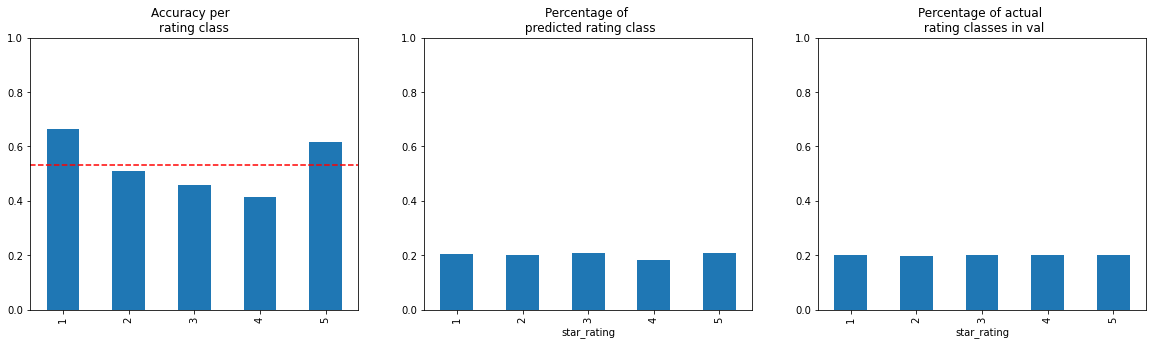

In [109]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
# 10000 features (/10 for variance threshold)

Start predicting
Finished predicting
Global accuracy: 0.5330777967064169


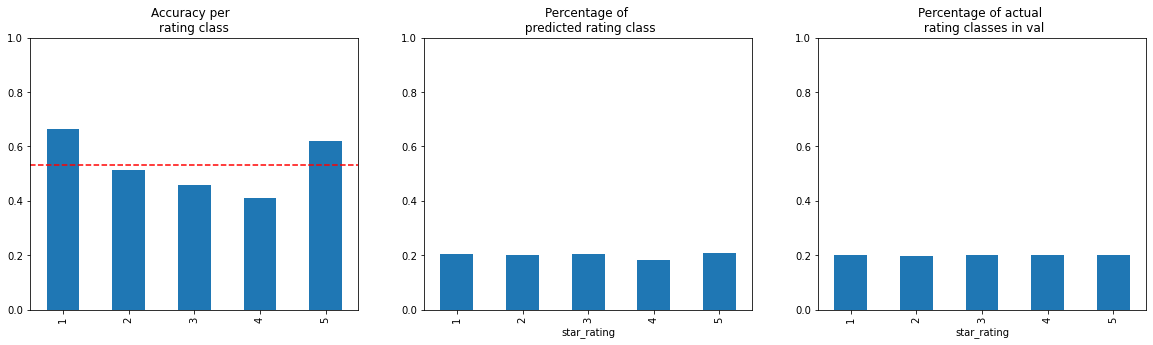

In [114]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
#/2 => 4000 features

Start predicting
Finished predicting
Global accuracy: 0.5342703009653605


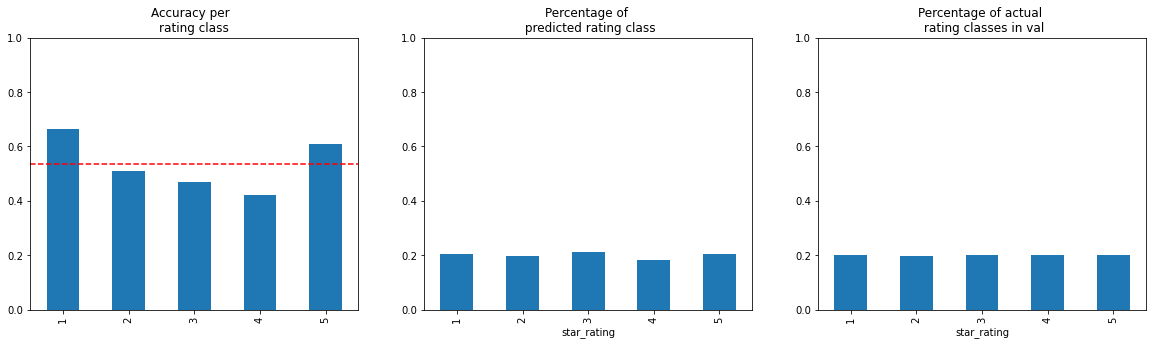

In [121]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
#1 

In [46]:
import joblib
joblib.dump(clf_knn, "knn_model_dump.sav")

['knn_model_dump.sav']

In [47]:
os.getcwd()

'D:\\sep22_10_supply_chain\\data'